# Dask: Parallel Computing Accelerates Data Processing

In this notebook, we'll conduct a rigorous performance comparison between traditional pandas and distributed Dask approaches for computational workloads. This analysis is essential for high-performance data analysis (HPDA) practitioners to understand:

- **Performance Scalability**: When does parallel computing provide actual speedup vs overhead costs
- **Memory Efficiency**: How distributed processing handles larger-than-memory datasets
- **Resource Optimization**: Balancing computation time, memory usage, and system resources
- **Real-World Benchmarking**: Practical performance testing with synthetic datasets representing typical physics simulations

## The Physics Simulation Scenario

We'll simulate a realistic physics measurement scenario:
- **Distance measurements** with experimental uncertainty (Gaussian distribution)
- **Time measurements** with high-precision timing (small relative error)
- **2D histogram analysis** for correlation pattern detection
- **Large dataset size** (100M samples) representing modern detector data volumes

This mirrors common HPDA patterns in:
- **Particle physics**: Track reconstruction, collision analysis
- **Astronomy**: Sky surveys, light curve analysis  
- **Geophysics**: Seismic data processing, climate modeling
- **Materials science**: Molecular dynamics simulations

In [2]:
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as mcolors
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [(0,0,0,0),(0,1,0,1),(1,0,0,1)], N=128)

In [ ]:
print(f"Available RAM: {psutil.virtual_memory().available / (1024 ** 3):.2f} GB")

Available RAM: 9.47 GB


# Problem Size Configuration

## Realistic Physics Simulation Parameters

The choice of **100 million samples** represents a typical mid-scale physics analysis scenario:

### Dataset Scale Justification

**Memory Footprint Estimation**:
- 100M samples × 2 float64 columns × 8 bytes = **~1.6 GB** base memory
- Well within typical workstation memory, but large enough to show performance differences

### Scaling Considerations

This problem size is strategically chosen because:

1. **Pandas Feasible**: Large enough to show computational cost, small enough to fit in memory
2. **Dask Beneficial**: Sufficient computational complexity to justify distributed overhead  
3. **Realistic**: Representative of actual experimental datasets in physics
4. **Benchmarkable**: Completes in reasonable time for performance analysis

**Performance Prediction**: At this scale, we expect pandas to be memory-bound while Dask leverages CPU parallelization. 

In [3]:
n_samples = 100_000_000
distance_mean_m = 100
distance_sigma_m = 10
time_mean_s = 10
time_sigma_s = 0.1

# Pandas Approach

### Pandas Strengths for This Problem

1. **Memory Efficiency**: Optimized C implementations for numerical operations
2. **Simplicity**: Straightforward, readable code with minimal setup overhead
3. **Ecosystem Integration**: Seamless compatibility with matplotlib, scipy, scikit-learn
4. **Debugging Ease**: Full data visibility, traditional debugging approaches work

### Expected Performance Characteristics

**Data Generation**: Creating 100M random samples tests:
- **Memory allocation**: Contiguous memory layout for efficient access patterns
- **Random number generation**: NumPy's optimized random number generators
- **DataFrame construction**: Pandas internal indexing and column management overhead

**Computational Bottlenecks**:
- **Single-threaded**: Cannot utilize multiple CPU cores for parallel processing
- **Memory bandwidth**: Performance limited by RAM speed rather than CPU speed
- **Cache efficiency**: Large datasets may exceed CPU cache, reducing performance

### Why This Serves as Our Baseline

**Performance Reference**: All distributed approaches should be compared against optimized single-machine performance. If Dask doesn't outperform pandas, the distributed overhead isn't justified for this problem size.

In [4]:
%time df1 = pd.DataFrame({"distance_m" : np.random.normal(loc=distance_mean_m, scale=distance_sigma_m, size=n_samples),"time_s": np.random.normal(loc=time_mean_s, scale=time_sigma_s, size=n_samples)})

CPU times: user 2.74 s, sys: 385 ms, total: 3.13 s
Wall time: 3.13 s


**Examining the generated data structure**:

- **Column names**: Clear, descriptive variable names following physics conventions
- **Data types**: float64 precision appropriate for scientific measurements
- **Value ranges**: Distance values around 100m, time values around 10s as expected
- **Distribution characteristics**: Values show expected Gaussian scatter patterns

In [5]:
df1.head()

,distance_m,time_s
0,82.317487,9.822238
1,105.753355,9.979076
2,125.447803,10.054397
3,98.978732,9.845889
4,88.769283,9.918279


### Computational Complexity: 2D Histogram Analysis

The `np.histogram2d()` operation represents a **computationally intensive** task perfect for performance benchmarking:

**Algorithm Complexity**:
- **Data traversal**: Every sample must be examined (O(n) data access)
- **Bin classification**: Each point requires 2D bin assignment (spatial locality)
- **Memory access patterns**: Histogramming creates irregular memory access to bin arrays
- **Accumulation operations**: Thread-unsafe increment operations challenge parallelization

**Performance Factors**:
- **500×500 bins** = 250,000 histogram bins requiring memory allocation and management
- **100M data points** require classification and accumulation across these bins
- **Cache behavior**: Large histogram arrays may exceed CPU cache, impacting performance

This operation perfectly demonstrates the type of CPU-intensive computation where parallel processing can provide significant speedup.

In [7]:
%time hist_pandas, xedges_pandas, yedges_pandas = np.histogram2d(df1.distance_m,df1.time_s,bins=500)

CPU times: user 8.71 s, sys: 520 ms, total: 9.23 s
Wall time: 9.24 s


### 2D Histogram Analysis

**Visualization Strategy for Large-Scale Data**:

Our visualization approach is optimized for **high-density data representation**:

1. **Logarithmic Color Scale**: `LogNorm(vmin=1, vmax=hist.max())` handles wide dynamic range
   - Low-count bins remain visible (avoiding zero-count issues)
   - High-count central region doesn't saturate the colormap
   - Essential for data spanning multiple orders of magnitude

2. **Custom Colormap**: `custom_cmap` provides intuitive scientific visualization
   - Transparent for zero counts  
   - Green for low-count regions (background/outliers)
   - Red for high-count regions (main distribution peak)

3. **Proper Coordinate System**: `extent` parameter maps bin indices to physical coordinates
   - X-axis: Distance measurements in meters
   - Y-axis: Time measurements in seconds
   - Preserves physical meaning of the data

**Physics Interpretation**: 
The resulting plot should show a **Gaussian concentration** around (100m, 10s) with:
- **Central peak**: Most measurements cluster around expected values
- **Symmetric spread**: Equal probability in all directions from the mean
- **Tail behavior**: Exponential falloff characteristic of Gaussian distributions

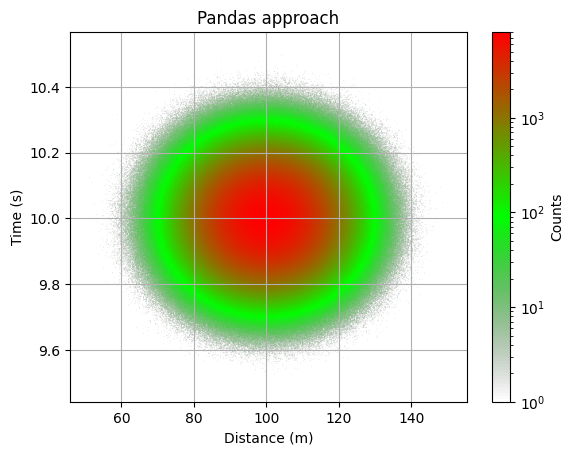

In [8]:
norm = mcolors.LogNorm(vmin=1, vmax=hist_pandas.max())

plt.imshow(
    hist_pandas.T,
    origin="lower",
    aspect="auto",
    extent=[xedges_pandas[0], xedges_pandas[-1], yedges_pandas[0], yedges_pandas[-1]],
    cmap=cmap,
    norm=norm
)
plt.xlabel("Distance (m)")
plt.ylabel("Time (s)")
plt.title("Pandas approach")
plt.colorbar(label="Counts")
plt.grid()

# Dask Approach
### Dask's Distributed Computing Model

**Key Advantages for This Problem**:

1. **Parallel Processing**: Histogram computation distributed across multiple CPU cores
2. **Lazy Evaluation**: Computation graphs optimized before execution

### Expected Performance Characteristics

**Distributed Overhead Factors**:
- **Task coordination**: Scheduler overhead for managing parallel tasks
- **Data serialization**: Moving data between processes incurs marshalling costs
- **Memory copying**: Inter-process communication requires data duplication
- **Thread synchronization**: Coordinating parallel histogram accumulation

**Performance Gains**:
- **CPU parallelization**: Utilize all available cores simultaneously  
- **Pipeline optimization**: Overlap computation with data movement
- **Memory efficiency**: Process data in chunks rather than loading everything
- **NUMA optimization**: Better utilization of multi-processor systems

### The Distributed Computing Trade-off

**When Dask Wins**: CPU-intensive operations with parallelizable algorithms
**When Pandas Wins**: Simple operations where coordination overhead exceeds parallelization benefits

**Critical Question**: For our 100M sample, 2D histogram problem, which approach will be faster?

### Distributed Client Initialization

The `Client()` call sets up Dask's **distributed computing infrastructure**:

**What Happens Behind the Scenes**:
- **Scheduler startup**: Central coordinator for task distribution and result collection
- **Worker processes**: Multiple Python processes (typically one per CPU core) 
- **Communication channels**: Network connections between scheduler and workers
- **Memory management**: Shared memory setup for efficient data transfer
- **Task queue**: Infrastructure for parallel job dispatch and completion tracking

**Resource Allocation Strategy**:
- **Default configuration**: Uses all available CPU cores as workers
- **Memory per worker**: Automatically allocates RAM based on system resources
- **Thread pools**: Each worker manages multiple threads for I/O overlap

**Dashboard Access**: The client provides a web dashboard (typically http://localhost:8787) for:
- **Real-time monitoring**: CPU usage, memory consumption, task progress
- **Performance profiling**: Bottleneck identification and optimization insights
- **Visual task graphs**: See your computation pipeline in action

**Performance Monitoring**: The displayed client information shows the exact worker configuration - crucial for understanding your computational resources.

In [9]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.29 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42827,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33467,Total threads: 3
Dashboard: http://127.0.0.1:42183/status,Memory: 3.82 GiB
Nanny: tcp://127.0.0.1:40051,


### Distributed Data Generation Strategy

**Dask Array Creation**: `da.random.normal()` creates **lazy arrays** that generate data on-demand:

**Key Differences from Pandas Approach**:
- **Lazy evaluation**: No memory allocated until computation triggered
- **Automatic chunking**: Data divided across workers using `chunks='auto'`
- **Distributed generation**: Random numbers generated in parallel across workers
- **Memory efficiency**: Only working chunks loaded into memory at any time

**Performance Implications**:
- **Generation overhead**: Each worker generates its chunk independently
- **Synchronization**: Random seeds managed to ensure reproducible results across workers
- **Memory distribution**: 1.6 GB dataset distributed across worker processes

**DataFrame Construction**: `dd.from_dask_array()` creates the distributed DataFrame:
- **Column mapping**: Transforms 2D array into structured DataFrame with named columns
- **Partition strategy**: Data automatically partitioned for optimal parallel processing
- **Lazy structure**: DataFrame operations build computation graphs rather than executing immediately

**Memory Advantage**: This entire operation uses essentially **zero memory** until `.compute()` is called - a fundamental difference from the pandas approach!

In [10]:

distance_m_dask = da.random.normal(loc=distance_mean_m, scale=distance_sigma_m, size=n_samples, chunks='auto')
time_s_dask = da.random.normal(loc=time_mean_s, scale=time_sigma_s, size=n_samples, chunks='auto')
df2 = dd.from_dask_array(da.stack([distance_m_dask, time_s_dask], axis=1), columns=['distance_m', 'time_s'])

In [11]:
df2.head()

,distance_m,time_s
0,92.667489,10.176861
1,98.825735,9.922000
2,119.356646,10.015581
3,105.991873,10.146057
4,90.664947,9.949982


### Distributed Histogram Computation Strategy

**Two-Stage Approach for Optimal Performance**:

The distributed histogram requires careful handling of **data range determination**:

**Stage 1: Range Computation**
```python
d_min, d_max, t_min, t_max = da.compute(distance_m_dask.min(), distance_m_dask.max(), time_s_dask.min(), time_s_dask.max())
```

**Why This Is Necessary**:
- **Consistent binning**: All workers must use identical bin boundaries  
- **Optimal range**: Tight bounds minimize empty bins and improve cache efficiency
- **Parallel min/max**: Each worker computes local extrema, then results are combined
- **Single computation**: `da.compute()` executes all four operations simultaneously

**Stage 2: Parallel Histogram Construction**
```python 
hist_dask, xedges_dask, yedges_dask = da.histogram2d(distance_m_dask, time_s_dask, bins=(500, 500), range=[[d_min, d_max], [t_min, t_max]])
```

**Distributed Algorithm**:
1. **Local histograms**: Each worker computes histogram for its data chunk
2. **Identical binning**: All workers use same `range` and `bins` parameters  
3. **Result aggregation**: Local histograms are summed to produce final result
4. **Load balancing**: Work distributed across available CPU cores

**Performance Optimization**: The explicit `range` parameter eliminates the need for workers to coordinate on bin boundaries, significantly improving parallel efficiency.

In [12]:
# Compute min/max first
d_min, d_max, t_min, t_max = da.compute(distance_m_dask.min(), distance_m_dask.max(), time_s_dask.min(), time_s_dask.max())

# Use the computed numbers
%time hist_dask, xedges_dask, yedges_dask = da.histogram2d(distance_m_dask, time_s_dask,bins=(500, 500),range=[[d_min, d_max], [t_min, t_max]])

CPU times: user 1.74 ms, sys: 57 μs, total: 1.8 ms
Wall time: 1.75 ms


### Computation Execution and Performance Analysis

**Critical Performance Timing**: This `.compute()` call executes the **entire distributed computation graph**:

**What Happens During Execution**:
1. **Task graph optimization**: Dask optimizes the computation pipeline before execution
2. **Data generation**: Workers generate their chunks of random data in parallel  
3. **Histogram computation**: Each worker processes its data chunk independently
4. **Result aggregation**: Local histogram results combined into final arrays
5. **Data serialization**: Results transferred back to main process

**Performance Factors**:
- **Parallel efficiency**: How well the computation scales across available cores
- **Communication overhead**: Time spent coordinating between workers
- **Memory management**: Peak memory usage during computation
- **CPU utilization**: Whether all cores are effectively utilized

**Benchmarking Strategy**: The `%time` magic captures the **total wall-clock time** including:
- Computation time across all workers
- Coordination overhead between scheduler and workers  
- Data transfer time for result collection
- Python interpreter overhead

**Expected Outcome**: This timing will be directly comparable to the pandas `np.histogram2d()` benchmark, allowing us to quantify the performance impact of distributed computing for this specific problem size.

In [13]:
%time hist_dask, xedges_dask, yedges_dask = da.compute(hist_dask, xedges_dask, yedges_dask)

CPU times: user 181 ms, sys: 40.5 ms, total: 221 ms
Wall time: 2.84 s


## Performance Analysis: Understanding the Results

### Interpreting the Timing Results

After running both approaches, compare the `%time` outputs to understand:

**Pandas Performance Profile**:
- **Data generation time**: Time to create 100M sample DataFrame
- **Histogram computation time**: `np.histogram2d()` execution time
- **Total memory usage**: Peak RAM consumption during processing
- **CPU utilization**: Typically single-core usage (~12.5% on 8-core system)

**Dask Performance Profile**:  
- **Setup overhead**: Client initialization and task graph construction
- **Distributed computation time**: Parallel execution across all workers
- **Communication overhead**: Data transfer and result aggregation
- **Memory distribution**: RAM usage spread across worker processes

### Expected Performance Patterns

**When Dask Should Win**:
- **CPU-intensive operations**: Histogram computation parallelizes well
- **Large datasets**: Distributed memory management advantages
- **Multi-core systems**: Better resource utilization

**When Pandas Should Win**:
- **Small datasets**: Coordination overhead exceeds computation benefit
- **Simple operations**: Distributed complexity not justified  
- **Memory-constrained systems**: Single-process efficiency

### Result Validation and Quality Assessment

**Critical Verification Step**: Before analyzing performance, we must verify that both approaches produce **identical results**:

**Expected Visualization**: The Dask-generated plot should be **visually identical** to the pandas version:
- Same Gaussian concentration around (100m, 10s)  
- Identical color scale and distribution patterns
- Same statistical properties (peak location, spread, tail behavior)

**Numerical Accuracy**: Any differences should be within **floating-point precision** limits. Significant discrepancies would indicate:
- Implementation bugs in the distributed algorithm
- Incorrect random number generation or seeding
- Binning inconsistencies between approaches

**Performance vs Correctness**: High-performance computing is meaningless without correctness - always validate results before trusting performance benchmarks.

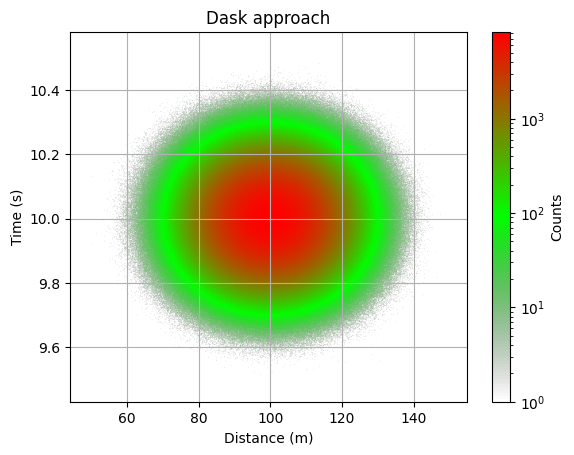

In [14]:
norm = mcolors.LogNorm(vmin=1, vmax=hist_dask.max())

plt.imshow(
    hist_dask.T,
    origin="lower",
    aspect="auto",
    extent=[xedges_dask[0], xedges_dask[-1], yedges_dask[0], yedges_dask[-1]],
    cmap=cmap,
    norm=norm
)
plt.xlabel("Distance (m)")
plt.ylabel("Time (s)")
plt.title("Dask approach")
plt.colorbar(label="Counts")
plt.grid()

# Advanced Performance Challenges

## 🚀 **Challenge 1: Scaling Analysis - Dataset Size Impact**

**Objective**: Systematically analyze how performance scaling changes with dataset size.

**Technical Implementation**:
```python
# TODO: Implement scaling analysis
# sample_sizes = [1_000, 10_000, 100_000, 1_000_000, 10_000_000, 100_000_000]
# pandas_times = []
# dask_times = []

# for n_samples in sample_sizes:
#     # Benchmark pandas approach
#     start_time = time.time()
#     df_pandas = pd.DataFrame({...})
#     hist_pandas, _, _ = np.histogram2d(df_pandas.distance_m, df_pandas.time_s, bins=500)  
#     pandas_time = time.time() - start_time
#     pandas_times.append(pandas_time)
    
#     # Benchmark Dask approach  
#     start_time = time.time()
#     distance_dask = da.random.normal(loc=distance_mean_m, scale=distance_sigma_m, size=n_samples, chunks='auto')
#     time_dask = da.random.normal(loc=time_mean_s, scale=time_sigma_s, size=n_samples, chunks='auto')
#     hist_dask, _, _ = da.histogram2d(distance_dask, time_dask, bins=500).compute()
#     dask_time = time.time() - start_time  
#     dask_times.append(dask_time)

# Plot scaling curves
# plt.loglog(sample_sizes, pandas_times, 'o-', label='Pandas')  
# plt.loglog(sample_sizes, dask_times, 's-', label='Dask')
# plt.xlabel('Dataset Size (samples)')
# plt.ylabel('Computation Time (seconds)')
# plt.legend()
# plt.grid(True)
```

**Learning Objectives**:
- Identify the **crossover point** where Dask becomes faster than pandas
- Understand **scaling behavior** - linear, sublinear, or superlinear performance 
- Measure **overhead costs** of distributed computing setup
- Quantify **parallel efficiency** as a function of problem size

**Expected Results**:
- **Small datasets** (< 10K samples): Pandas significantly faster due to setup overhead
- **Medium datasets** (10K-1M samples): Performance convergence zone
- **Large datasets** (> 1M samples): Dask advantages become pronounced
- **Memory limits**: Identify when pandas approaches system memory constraints



## 🧮 **Challenge 2: Minimal Dataset Efficiency Study**

**Objective**: Determine the smallest dataset size where distributed computing becomes beneficial.

**Experimental Design**:
```python
# TODO: Implement minimal efficiency analysis
# small_sizes = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
# efficiency_metrics = []

# for size in small_sizes:
#     # Measure setup overhead
#     setup_start = time.time()
#     client = Client()  # Fresh client for each test
#     setup_time = time.time() - setup_start
    
#     # Measure computation time
#     comp_start = time.time() 
#     distance_dask = da.random.normal(loc=100, scale=10, size=size, chunks='auto')
#     time_dask = da.random.normal(loc=10, scale=0.1, size=size, chunks='auto')
#     result = da.histogram2d(distance_dask, time_dask, bins=100).compute()
#     comp_time = time.time() - comp_start
#     total_time = setup_time + comp_time
    
#     # Compare with pandas
#     pandas_start = time.time()
#     df = pd.DataFrame({
#         "distance_m": np.random.normal(loc=100, scale=10, size=size),
#         "time_s": np.random.normal(loc=10, scale=0.1, size=size)
#     })
#     pandas_hist = np.histogram2d(df.distance_m, df.time_s, bins=100)
#     pandas_time = time.time() - pandas_start
    
#     efficiency = pandas_time / total_time  # > 1.0 means Dask is faster
#     efficiency_metrics.append({
#         'size': size,
#         'setup_overhead': setup_time,
#         'dask_total': total_time, 
#         'pandas_time': pandas_time,
#         'efficiency_ratio': efficiency
#     })
#     
#     client.close()  # Clean shutdown
```

**Critical Questions**:
- What is the **minimum dataset size** where Dask setup overhead is justified?
- How does **client initialization time** compare to actual computation time?
- Can **client reuse** strategies improve small-dataset performance?